# Introduction



### History

2018 was a breakthrough year in NLP. 

Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state-of-the-art results.

### What is BERT?

**BERT (Bidirectional Encoder Representations from Transformers)** is a method of pretraining language representations that was used to create models that we can then download and use for free. 

You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce predictions.


### Why BERT embeddings?

BERT can be used to **extract features, namely word and sentence embedding vectors, from text data**. What can we do with these word and sentence embedding vectors? 

First, these embeddings are useful for `keyword/search expansion, semantic search and information retrieval`. For example, if you want to match customer questions or searches against already answered questions or well documented searches, these representations will help you accurately retrieve results matching the customer's intent and contextual meaning, even if there's no keyword or phrase overlap.

Second, and perhaps more importantly, these vectors are used as `high-quality feature inputs to downstream models`. NLP models such as LSTMs or CNNs require inputs in the form of numerical vectors, and this typically means translating features like the vocabulary and parts of speech into numerical representations. In the past, words have been represented either as uniquely indexed values (one-hot encoding), or more helpfully as neural word embeddings where vocabulary words are matched against the fixed-length feature embeddings that result from models like Word2Vec or Fasttext. BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, **BERT produces word representations that are dynamically informed by the words around them**. For example, given two sentences:

- "The man was accused of robbing a bank."
- "The man went fishing by the bank of the river."

Word2Vec would produce the same word embedding for the word "bank" in both sentences, while under BERT the word embedding for "bank" would be different for each sentence. Aside from capturing obvious differences, the **context-informed word embeddings** capture other forms of information that result in more accurate feature representations, which in turn results in better model performance.

## 1. Loading Pre-Trained BERT

Install the pytorch interface for BERT by Hugging Face.

In [1]:
pip install torch


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Now import `pytorch`, `the pretrained BERT model`, and a `BERT tokenizer`.

BERT model is the pre-trained model released by Google that ran on Wikipedia and [Book Corpus](https://arxiv.org/pdf/1506.06724.pdf), a dataset containing +10,000 books of different genres. Google released a few variations of BERT models, but the one we'll use here is the smaller of the two available sizes ("base" and "large") and ignores casing, hence "uncased."

`transformers` provides a number of classes for applying BERT to different tasks (token classification, text classification, ...). Here, we're using the basic `BertModel` which has no specific output task, it's just used for embeddings.

In [3]:
import torch
from transformers import BertTokenizer, BertModel

import logging

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Input Formatting
Because BERT is a pretrained model that expects input data in a specific format, we need:

1. A **special token, `[SEP]`,** to mark the end of a sentence, or the separation between two sentences
2. A **special token, `[CLS]`,** at the beginning of our text. This token is used for classification tasks, but BERT expects it no matter what your application is.
3. Tokens that conform with the fixed vocabulary used in BERT
4. The **Token IDs** for the tokens, from BERT's tokenizer
5. **Mask IDs** to indicate which elements in the sequence are tokens and which are padding elements
6. **Segment IDs** used to distinguish different sentences
7. **Positional Embeddings** used to show token position within the sequence

`transformers` interface takes care of all of the above requirements using the `tokenizer.encode_plus` function. (We will go through most of these manually here.)

### 2.1. Special Tokens
The special token `[SEP]` is used to differentiate sentences. 

The `[CLS]` token always appears at the start of the text.

Both tokens are **always required**, even if we only have one sentence, and even if we are not using BERT for classification. 

**2 Sentence Input**:

`[CLS] The man went to the store. [SEP] He bought a gallon of milk.`

**1 Sentence Input**:

`[CLS] The man went to the store. [SEP]`



### 2.2. Tokenization

BERT provides its own tokenizer, `BertTokenizer`, which we imported above. 

In [ ]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


The word **"embeddings"** is tokenized as:

`['em', '##bed', '##ding', '##s']`

The original word has been split into smaller subwords and characters. **'##'** are BERT tokenizer's way to denote that this subword or character is part of a larger word and preceded by another subword.  

Why does it look this way? This is because the BERT tokenizer was created with a WordPiece model. This model creates a fixed-size vocabulary of individual characters, subwords, and words that best fits our language data. The WordPiece model generated a vocabulary that contains all English characters plus the most common words and subwords. This contains:

1. Whole words
2. Subwords occuring at the front of a word or in isolation ("em" as in "embeddings" is assigned the same vector as the standalone sequence of characters "em" as in "go get em" )
3. Subwords not at the front of a word, which are preceded by '##' to denote this case
4. Individual characters

To tokenize a word under this model, the tokenizer first checks if the whole word is in the vocabulary. If not, it tries to break the word into the largest possible subwords contained in the vocabulary, and as a last resort will decompose the word into individual characters. Then we can represent a word as the collection of its individual characters.

Splitting into subword tokens ['em', '##bed', '##ding', '##s'] will retain some of the contextual meaning of the original word. 

Some examples of the tokens contained in the vocabulary:

In [4]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

After breaking the text into tokens, we then have to convert the sentence from a `list of strings` to a `list of vocabulary indeces`.

The example sentence below contains two instances of the word `"bank"` with different meanings.

In [5]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


### 2.3 Segment ID
BERT is trained on and expects sentence pairs, `using 1s and 0s to distinguish between the two sentences`. That is, for each token in "tokenized_text," we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). 

**Single-sentence** inputs only require a series of 1s, so we create a vector of 1s for each token in our input sentence.

For **two sentences**, assign each word in the first sentence plus the '[SEP]' token a 0, and all tokens of the second sentence a 1.

In [6]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## 3. Extracting Embeddings
### 3.1. Running BERT on the text

Next we convert our data to `torch tensors` and `call the BERT model`. (BERT PyTorch interface requires that the data be in torch tensors rather than Python lists)

In [7]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [8]:
tokens_tensor

tensor([[  101,  2044, 11065,  2769,  2013,  1996,  2924, 11632,  1010,  1996,
          2924, 27307,  2001,  2464,  5645,  2006,  1996,  5900,  2314,  2924,
          1012,   102]])

In [9]:
segments_tensors

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

Calling `from_pretrained` will fetch the model from the internet. When we load the `bert-base-uncased`, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers. 

`model.eval()` puts our model in evaluation mode as opposed to training mode. Evaluation mode turns off dropout regularization which is used in training.

In [10]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Let's evaluate BERT on our example text, and fetch the hidden states of the network.

In [21]:
# Run the text through BERT, and collect all hidden states produced from 12 layers
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on
    # how it's configured in the `from_pretrained` call earlier. In this case,
    # we set `output_hidden_states = True`, so the third item will be the
    # hidden states from all layers. 
    hidden_states = outputs[2]

### 3.2. Understanding the Output


The full set of hidden states for this model is stored in `hidden_states`. This object has four dimensions, in the following order:

1. The layer number (13 layers)
2. The batch number (1 sentence)
3. The word / token number (22 tokens in our sentence)
4. The hidden unit / feature number (768 features)

It's 13 layers because the first element is the input embeddings, the rest is the outputs of each of BERT's 12 layers.

The second dimension (batch size) is used when submitting multiple sentences to the model at once.

In [12]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


Let's take a quick look at the range of values for a given layer and token.

The range is fairly similar for all layers and tokens, with the majority of values falling between \[-2, 2\].

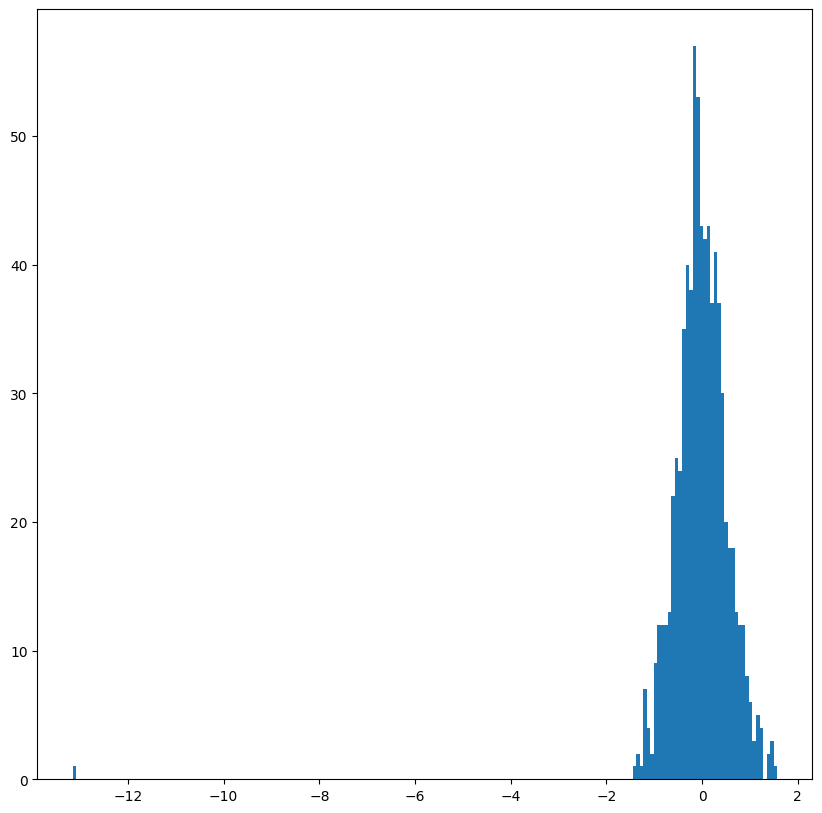

In [13]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

For our purposes, we want to group by each token.

Current dimensions:

`[# layers, # batches, # tokens, # features]`

Desired dimensions:

`[# tokens, # layers, # features]`

`permute` function in PyTorch rearranges the dimensions of a tensor.

(The first dimension is currently a Python list)

In [14]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


Combine the layers to make one whole big tensor.

In [ ]:
# Concatenate the tensors for all layers
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [17]:
# Remove the "batches" dimension since we don't need it
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [18]:
token_embeddings.shape

torch.Size([13, 22, 768])

In [19]:
token_embeddings

tensor([[[ 1.6855e-01, -2.8577e-01, -3.2613e-01,  ..., -2.7571e-02,
           3.8253e-02,  1.6400e-01],
         [ 2.3295e-01,  1.3898e-01,  2.9788e-01,  ..., -6.5465e-02,
           8.8849e-01,  5.1089e-01],
         [ 2.2572e-01, -7.1647e-01, -7.2547e-01,  ...,  4.8439e-01,
           6.0302e-01, -9.5701e-02],
         ...,
         [-3.7402e-02, -6.1545e-01, -1.4419e+00,  ...,  7.9256e-02,
          -8.1097e-02, -3.8018e-01],
         [-2.2755e-02,  4.2067e-01, -3.2878e-01,  ...,  4.4641e-01,
           5.1775e-01,  5.5010e-01],
         [-2.3496e-01,  1.5656e-01, -4.6245e-02,  ..., -4.2065e-01,
           3.0737e-01, -2.2883e-01]],

        [[ 5.2195e-02,  5.9527e-02, -2.1788e-01,  ...,  2.2799e-01,
          -7.1235e-02,  1.4849e-02],
         [ 3.8188e-01,  1.4754e-01,  2.4141e-01,  ...,  3.3967e-01,
           7.6073e-01,  4.9991e-01],
         [ 1.7047e-01, -6.1683e-01, -7.2964e-01,  ...,  8.6309e-01,
           6.2739e-01, -3.7271e-01],
         ...,
         [ 6.9817e-01, -4

Switch around the "layers" and "tokens" dimensions with `permute`.

In [20]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

### 3.3. Creating word and sentence vectors from hidden states

What do we do with these hidden states? 

We would like to get individual vectors for each tokens, or a single vector representation of the whole sentence.

But for each token, we have 13 separate vectors each of length 768.

In order to get the individual vectors we will need to combine some of the layer vectors, but which layer or combination of layers provides the best representation?

There's no single answer, but there's two reasonable approaches.

#### Word Vectors

First, let's **concatenate** the last four layers, giving us a single word vector per token. Each vector will have length `4 x 768 = 3,072`.

In [22]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


As an alternative method, let's try creating the word vectors by **summing** together the last four layers.

In [23]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)

    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


### Sentence Vectors



To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [22]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


### 3.4. Confirming contextually dependent vectors

To confirm that the value of these vectors are in fact contextually dependent, let's look at the different instances of the word "bank" in our example sentence:

"After stealing money from the **bank vault**, the **bank robber** was seen fishing on the Mississippi **river bank**."

Let's find the index of those three instances of the word "bank" in the example sentence.

In [23]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


They are at 6, 10, and 19.

For this analysis, we'll use the word vectors that we created by summing the last four layers.

We can try printing out their vectors to compare them.

In [24]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


We can see that the values differ, but let's calculate the cosine similarity between the vectors to make a more precise comparison.

In [25]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69


This looks pretty good!

### 3.5. Pooling Strategy & Layer Choice

Below are a couple additional resources for exploring this topic.

**BERT Authors**

The BERT authors tested word-embedding strategies by feeding different vector combinations as input features to a BiLSTM used on a named entity recognition task and observing the resulting F1 scores.

(Image from [Jay Allamar](http://jalammar.github.io/illustrated-bert/)'s blog)


![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

While concatenation of the last four layers produced the best results on this specific task, many of the other methods come in a close second and in general it is advisable to test different versions for your specific application: results may vary.

This is partially demonstrated by noting that the different layers of BERT encode very different kinds of information, so the appropriate pooling strategy will change depending on the application because different layers encode different kinds of information.


**Han Xiao's BERT-as-service**

Han Xiao created an open-source project named [bert-as-service](https://github.com/hanxiao/bert-as-service) on GitHub which is intended to create word embeddings for your text using BERT. Han experimented with different approaches to combining these embeddings, and shared some conclusions and rationale on the [FAQ page](https://github.com/hanxiao/bert-as-service#speech_balloon-faq) of the project.

`bert-as-service`, by default, uses the outputs from the **second-to-last layer** of the model.

I would summarize Han's perspective by the following:

1. The embeddings start out in the first layer as having no contextual information (i.e., the meaning of the initial 'bank' embedding isn't specific to river bank or financial bank).
2. As the embeddings move deeper into the network, they pick up more and more contextual information with each layer.
3. As you approach the final layer, however, you start picking up information that is specific to BERT's pre-training tasks (the "Masked Language Model" (MLM) and "Next Sentence Prediction" (NSP)).
    * What we want is embeddings that encode the word meaning well...
    * BERT is motivated to do this, but it is also motivated to encode anything else that would help it determine what a missing word is (MLM), or whether the second sentence came after the first (NSP).
4. The second-to-last layer is what Han settled on as a reasonable sweet-spot.


